# Vehicle Detection and Tracking

The goals / steps of this project are the following:

1. Load data
2. Feature extraction
3. Train a classifier
4. Object detection using Sliding Window Technique
5. Use heatmap to combine and filter out false positive
6. Detect Vehicle from video stream
7. Combining Lane Detection and Vehicle Detection

## 1. Load Data



In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import math

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label


#make this notebook plot automatically
%matplotlib inline


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#glob relate files
images = glob.glob('imgs/**/*.png',recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
                
print("Cars = ",len(cars))
print("Not cars = ",len(notcars))

Cars =  8792
Not cars =  8968


## 2. Feature Extraction

Features that I am using is:

1. Color
2. Histrogram of color
3. HOG (Histogram of Oriented Gradient)

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
#     print(img.shape) #64,64,3
    img_features = []
    
    feature_image = None
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    
    
        
#     print(feature_image.shape) #64,64,3
#     print(spatial_size) #64,64
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
#         print("spatial_features.shape",spatial_features.shape) #(12288,)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
#         if count == 1:
#             count += 1
#             print(hist_features)
#         print("hist_features.shape",hist_features.shape)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         print("len(hog_features)",len(hog_features))
        img_features.append(hog_features)

    return np.concatenate(img_features)


# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        img = mpimg.imread(file)
        file_features = single_img_features(img
                                            ,color_space
                                            ,spatial_size
                                            ,hist_bins
                                            ,orient
                                            ,pix_per_cell
                                            ,cell_per_block
                                            ,hog_channel
                                            ,spatial_feat=spatial_feat
                                            ,hist_feat=hist_feat
                                            ,hog_feat=hog_feat
                                           )
        features.append(file_features)
    return features

### **Parameters**

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb -->hls good,HSV good, YUV/LUV doesn't run, YCrCb picks up too many false positive
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 100    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


In [6]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=200)

print("n of X_train =", len(X_train))
# from scipy import stats
# print(stats.describe(X_train))
print("n of X_test =", len(X_test))
print("n of y_train =", len(y_train))
print("n of y_test =", len(y_test))
print(len(y_test.nonzero()[0]))

n of X_train = 14208
n of X_test = 3552
n of y_train = 14208
n of y_test = 3552
1743


## 3.Train a classifier

In [8]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))


Test Accuracy of SVC =  0.992398648649


## 4. Object Detection using Sliding Window

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    contains_car = []
    for window in windows:
        #Extract the test window from original image
        cropped_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features 
        features = single_img_features(cropped_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            contains_car.append(window)

    return contains_car


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

In [10]:
def custom_sliding_window(img, start_x,stop_x,start_y,stop_y,window_width,window_height, step_x, step_y):

    window_list = []
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    for i in range(len(start_x)):
        #bot left
        window_list.append(((start_x[i], start_y[i] - window_height[i]),(start_x[i]+window_width[i], start_y[i])))
        #top left
#         window_list.append(((start_x[i], stop_y[i]),(start_x[i]+window_width[i], stop_y[i]+window_height[i])))
        #bot right
        window_list.append(((stop_x[i]-window_width[i], start_y[i] - window_height[i]),(stop_x[i], start_y[i])))
        #top right
#         window_list.append(((stop_x[i]-window_width[i], stop_y[i]),(stop_x[i], stop_y[i]+window_height[i])))

        #between
        curr_bot = start_y[i] + step_y[i]
        while True:
            
            curr_bot = curr_bot - step_y[i]
            if curr_bot - window_height[i] < stop_y[i]:
                break
            curr_left = start_x[i]
            while True:
                
                curr_left = curr_left + step_x[i]
                if curr_left + window_width[i] > stop_x[i]:
                    break
                    
                window_list.append(((curr_left, curr_bot-window_height[i]),(curr_left+window_width[i], curr_bot)))
                    
        
    # Return the list of windows
    return window_list

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     print(orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.0
    
    img_tosearch = img[ystart:ystop,:,:]
#     print("img_tosearch.shape",img_tosearch.shape)
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
#     ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)

#     print(ctrans_tosearch)
#     print("--------------")
#     print(ctrans_tosearch2)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
#     print("ctrans_tosearch.shape", ctrans_tosearch.shape)

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
#     print(ch1.shape)
#     print(ch2.shape)
#     print(ch3.shape)

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1 #2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     print("hog1.shape",hog1.shape)
    window_with_car = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             print("len(hog_features)",len(hog_features))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
#             print("subimg", subimg.shape)
            spatial_features = bin_spatial(subimg, size=spatial_size)
#             print("spatial_features.shape",spatial_features.shape)
            hist_features = color_hist(subimg, nbins=hist_bins)
#             print("hist_features.shape",hist_features.shape)
#             print("hog_features.shape",hog_features.shape)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_with_car.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return window_with_car

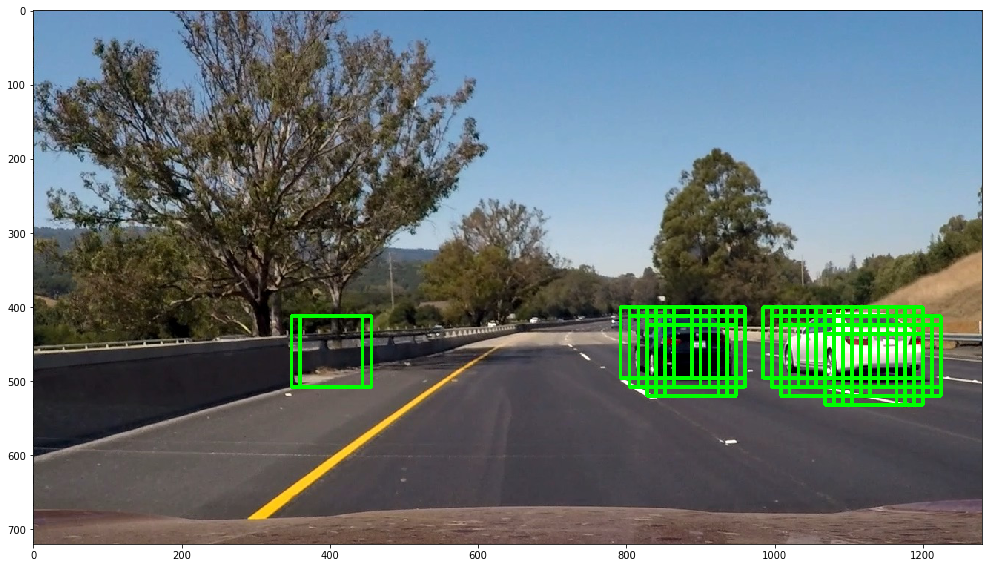

In [12]:
# img = mpimg.imread('test_images/bbox-example-image.jpg')
img = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(img)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# scaled_image = img.astype(np.float32)/255


# y_start_stop = [400, None] # Min and max in y to search in slide_window()
# search_window_size = (100,100)

# img_width = img.shape[1]
# img_height = img.shape[0]
# all_windows = custom_sliding_window(scaled_image
#                                     , start_x = [0,0]
#                                     , stop_x = [img_width,img_width]
#                                     , start_y = [680,680]
#                                     , stop_y = [370,370]
#                                     , window_width = [128,200]
#                                     , window_height = [128,200]
#                                     , step_x = [10,24]
#                                     , step_y = [10,24])

#                                     , start_x = [200]
#                                     , stop_x = [900]
#                                     , start_y = [580]
#                                     , stop_y = [480]
#                                     , window_width = [64]
#                                     , window_height = [64]
#                                     , step_x = [16]
#                                     , step_y = [16])
                                    
#                                     , start_x = [350]
#                                     , stop_x = [750]
#                                     , start_y = [580]
#                                     , stop_y = [500]
#                                     , window_width = [32]
#                                     , window_height = [32]
#                                     , step_x = [8]
#                                     , step_y = [8])

# print("total search windows = ",len(all_windows))
# plt.figure(figsize=(17, 13))
# plt.imshow(draw_boxes(img,all_windows,color=(0, 255, 0,), thick=3))

# windows_with_car = search_windows(scaled_image, all_windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)
ystart = 400
ystop = 656
scale = 1.5

windows_with_car = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

draw_image = draw_boxes(draw_image, windows_with_car, color=(0, 255, 0), thick=3)                    
plt.figure(figsize=(17, 13))
plt.imshow(draw_image)


# 5. Use heatmap to combine and filter out false positive


In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

        
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

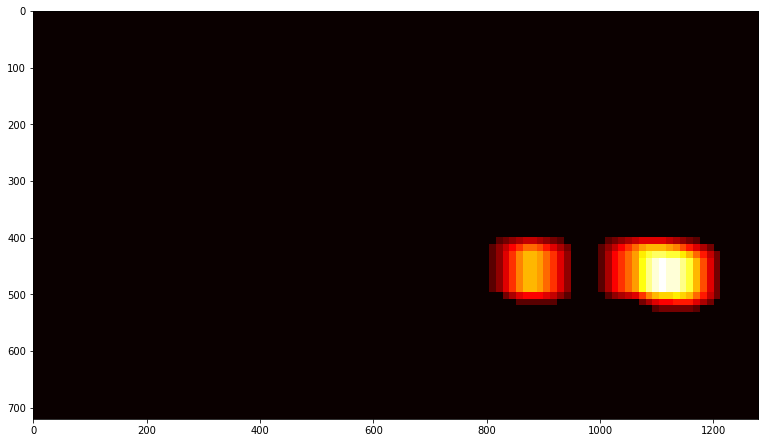

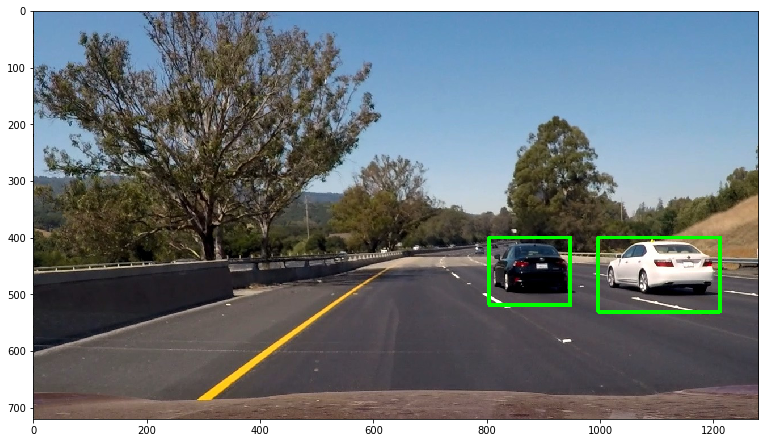

In [14]:
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,windows_with_car)

threshold = 2
heatmap = apply_threshold(heatmap,threshold)
heatmap = np.clip(heatmap, 0, 255)

plt.figure(figsize=(13, 13))
plt.imshow(heatmap,cmap='hot',interpolation='nearest')

# Find final boxes from heatmap using label function
labels = label(heatmap)
result = draw_labeled_bboxes(np.copy(img), labels)
plt.figure(figsize=(13, 13))
plt.imshow(result)

# 6. Detect Vehicles from Video Stream

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

count = 1
def procese_image(img):
    global count
    try:
        
        result = np.copy(img)
#         img = result.astype(np.float32)/255

        ystart = 400
        ystop = 656
        scale = 1.5
        windows_with_car = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


#         all_windows = custom_sliding_window(img
#                                     , start_x = [0,0]
#                                     , stop_x = [img_width,img_width]
#                                     , start_y = [680,680]
#                                     , stop_y = [370,370]
#                                     , window_width = [128,200]
#                                     , window_height = [128,200]
#                                     , step_x = [10,24]
#                                     , step_y = [10,24])
        
#         windows_with_car = search_windows(img, all_windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap,windows_with_car)

        threshold = 2
        heatmap = apply_threshold(heatmap,threshold)
        heatmap = np.clip(heatmap, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        result = draw_labeled_bboxes(result, labels)
        return result
    
    except Exception as e:
        print(str(e))
        return img

In [16]:
output_path = "result/2.mp4"

In [17]:
clip = VideoFileClip('project_video.mp4')
# clip = VideoFileClip('test_video.mp4')
# clip = VideoFileClip('original/harder_challenge_video.mp4')
result_clip = clip.fl_image(procese_image)
%time result_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video result/2.mp4
[MoviePy] Writing video result/2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:54<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result/2.mp4 

Wall time: 26min 55s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

# 7. Combining Vehicle Detection and Lane Detection

In [19]:
def getCameraParams():

    # prepare object points, like (0,0,0), (1,0,0), ..., (8,0,0),(0,1,0),(0,2,0),....,(8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape((-1,2)) #pythonian magic to make (x,y,0) coordinate array

    cal_images = glob.glob('./camera_cal/calibration*.jpg')
#     print("cal_images.len",len(cal_images))

    objPoints = []
    imgPoints = []
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if found:
            objPoints.append(objp)
            imgPoints.append(corners)
            
    
    img = cv2.imread("./camera_cal/calibration3.jpg")
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
    
    return mtx, dist
    

In [20]:
def binaryThreshold(img):
    
    gradX_binary = abs_sobel_thresh(img,orient='x',thresh_min=100,thresh_max=110,ksize=5)
    gradY_binary = abs_sobel_thresh(img,orient='y',thresh_min=100,thresh_max=110,ksize=5)
#     mag_binary = mag_thresh(img,30,100,9)
#     dir_binary = dir_threshold(img,15,(0.7,1.3))
    colored = color_thresh(img)
    
    combined = np.zeros_like(gradX_binary)
    combined[(((gradX_binary == 1) & (gradY_binary == 1)) | (colored == 1))] = 1
    return combined


def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, ksize=3, inverse=False):
    
    gray = img
    if(len(img.shape) == 3):
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    sorbeled = None
    filler = None
    op = None
    if inverse:
        filler = 0
        op = np.ones_like
    else:
        filler = 1
        op = np.zeros_like

    ksize = 31 if ksize > 31 else ksize # max at 31
    if orient == 'x':
        sorbeled = np.sqrt(np.square(np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = ksize))))
    else:
        sorbeled = np.sqrt(np.square(np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = ksize))))

    # scale to 255 max
    sorbeled = np.uint8((sorbeled / np.max(sorbeled)) * 255)

    binary_output = op(sorbeled)
    binary_output[(sorbeled >= thresh_min) & (sorbeled <= thresh_max)] = filler

    return binary_output


def mag_thresh(img, thresh_min=0,thresh_max=255,ksize=3):

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ksize = 31 if ksize > 31 else ksize # max at 31
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # scale to 255 max
    gradmag = np.uint8((gradmag / np.max(gradmag)) * 255)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return binary_output


def color_thresh(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    b = img[:,:,0]
    g = img[:,:,1]
    r = img[:,:,2]
    
    binary = np.zeros_like(S)
    binary[( ((S > 90) & (S <= 255) & (H >75) & (H < 109)) | (r > 205) )] = 1
    return binary
    

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    thresh_min,thresh_max = thresh
    ksize = sobel_kernel

    gray = img
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ksize = 31 if ksize > 31 else ksize # max at 31
    msobelx = np.absolute( cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize) )
    msobely = np.absolute( cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize) )
    # Calculate the gradient magnitude
    result = np.arctan2(msobely,msobelx)

    binary_output = np.zeros_like(result)
    binary_output[(result >= thresh_min) & (result <= thresh_max)] = 1
    
    return binary_output



In [21]:
def getPerspectiveTransformMatrix():
    
    t = 0
    l = 333
    b = 720
    r = 976
    
    height = 720
    src = np.float32([(200,720),(579,461),(709,461),(1100,720)])
    dst = np.float32([(l,b),(l,t),(r,t),(r,b)])


    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M,M_inv

In [22]:
def computeCurve(img):
    
    leftx_base = 0
    rightx_base = 0
    
    # Take a histogram of the bottom third of the image
    histogram = np.sum(img[img.shape[0]/3:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        # basically see how many pixel in the box that is white
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

#     print(leftx)
#     print(lefty)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit,right_fit,left_fit_cr,right_fit_cr),np.max(lefty)

In [23]:
def getLCurve(fit,size):
    Y = np.linspace(0, size[0]-1, size[0],dtype=int)
    X = (fit[0] * (Y**2)) + (fit[1]*Y) + fit[2]
    return np.array([np.transpose(np.vstack([X, Y]))])


def getRCurve(fit,size):
    
    Y = np.linspace(0, size[0]-1, size[0],dtype=int)
    X = (fit[0] * (Y**2)) + (fit[1]*Y) + fit[2]
    return np.array([np.flipud(np.transpose(np.vstack([X, Y])))])


def combineLR(L,R):
    return np.hstack((L, R))
    

def overlay(background,LR,M_inv):
    
    blank = np.zeros_like(background)
    
    cv2.fillPoly(blank, np.int_([LR]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(blank, M_inv, (blank.shape[1],blank.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(background, 1, newwarp, 0.3, 0)
    return result

In [24]:

def computeCurve_in_metre(y_eval,left_fit_cr,right_fit_cr):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [25]:
def computeAvg(history):

    sumLR = np.array([.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0,.0])
    for f in history:
        count = 0
        for lrlr in f:
            for i in lrlr:
                sumLR[count] += i
                count += 1
                count = count % 12
    
    n = float(len(history))
    avg = sumLR/n
    avg = avg.reshape(-1,3)
    return avg

In [26]:
history = []

def procese_image_all(image):
    global history
    try:
        
        mtx,dist = getCameraParams()
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        thresholdedImg = binaryThreshold(undist)
        img_size = thresholdedImg.shape[::-1]
        M,M_inv = getPerspectiveTransformMatrix()
        warped_img = cv2.warpPerspective(thresholdedImg, M, img_size, flags=cv2.INTER_LINEAR)
        fit,max_y = computeCurve(warped_img)
        history.append(fit)
        avg_fit = computeAvg(history)
        fitL,fitR,fitCL,fitCR = avg_fit
        history = history[-11:]
        L = getLCurve(fitL,image.shape)
        R = getRCurve(fitR,image.shape)
        LR = combineLR(L,R)
        
        
        left_curverad, right_curverad = computeCurve_in_metre(max_y,fitCL,fitCR)
        curve_rad = (left_curverad + right_curverad)/2
        result = overlay(undist,LR,M_inv)
        offcenter = ((image.shape[1]/2) - ((L[0][719][0]+R[0][719][0])/2)) * (3.7/700) # (3.7/700) <-- metre per pixel
        offcenter_txt = "left" if offcenter < 0 else "right"
        cv2.putText(result,"Radius of the curvature = "+str(int(curve_rad))+ " (m)", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200,200,200))
        cv2.putText(result,"The vehicle is " + "{:.2f}".format(abs(offcenter))  + "m " + offcenter_txt+ " of center", (50,80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200,200,200))
        
        
        ## start classifier portion
        ystart = 400
        ystop = 656
        scale = 1.5
        windows_with_car = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap,windows_with_car)

        threshold = 2
        heatmap = apply_threshold(heatmap,threshold)
        heatmap = np.clip(heatmap, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        result = draw_labeled_bboxes(result, labels)
        return result
    
    except Exception as e:
        print(str(e))

In [27]:
final_output_path = "result/all.mp4"
clip = VideoFileClip('project_video.mp4')
# clip = VideoFileClip('test_video.mp4')
result_clip = clip.fl_image(procese_image_all)
%time result_clip.write_videofile(final_output_path, audio=False)

[MoviePy] >>>> Building video result/all.mp4
[MoviePy] Writing video result/all.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:39:29<00:07,  7.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result/all.mp4 

Wall time: 2h 39min 30s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(final_output_path))